In [1]:
import pandas as pd
import numpy as np
import subprocess
import random
from scipy import stats
import glob
import math
import csv
import sys
import os

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
%matplotlib inline

In [2]:
# declarations
base_dir_data = "/ccb/salz8-1/avaraby/tx_noise/data/"
base_dir_out = "/ccb/salz8-1/avaraby/tx_noise/full_analysis_t3_s10_26022020/GTEx_aggs/"
out_dir = "/ccb/salz8-1/avaraby/tx_noise/full_analysis_t3_s10_26022020/sim_samples/"

readlen = 101
num_tissues = 3
num_samples = 10

gff3cols=["seqid","source","type","start","end","score","strand","phase","attributes"]

In [3]:
# first load all annotations into containers for processing later
real_gtfs = [list() for x in range(num_tissues)]
splicing_gtfs = [list() for x in range(num_tissues)]
intronic_gtfs = [list() for x in range(num_tissues)]
intergenic_gtfs = [list() for x in range(num_tissues)]

for tissue_num in range(num_tissues):
    for sample_num in range(num_samples):
        real_gtfs[tissue_num].append(pd.read_csv(out_dir+"real.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",names=gff3cols))
        splicing_gtfs[tissue_num].append(pd.read_csv(out_dir+"splicing.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",names=gff3cols))
        intronic_gtfs[tissue_num].append(pd.read_csv(out_dir+"intronic.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",names=gff3cols))
        intergenic_gtfs[tissue_num].append(pd.read_csv(out_dir+"intergenic.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",names=gff3cols))
        
        real_gtfs[tissue_num][-1] = real_gtfs[tissue_num][-1][real_gtfs[tissue_num][-1]["type"]=="transcript"].reset_index(drop=True)
        splicing_gtfs[tissue_num][-1] = splicing_gtfs[tissue_num][-1][splicing_gtfs[tissue_num][-1]["type"]=="transcript"].reset_index(drop=True)
        intronic_gtfs[tissue_num][-1] = intronic_gtfs[tissue_num][-1][intronic_gtfs[tissue_num][-1]["type"]=="transcript"].reset_index(drop=True)
        intergenic_gtfs[tissue_num][-1] = intergenic_gtfs[tissue_num][-1][intergenic_gtfs[tissue_num][-1]["type"]=="transcript"].reset_index(drop=True)
        
        real_gtfs[tissue_num][-1]["lid"] = real_gtfs[tissue_num][-1].attributes.str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        splicing_gtfs[tissue_num][-1]["lid"] = splicing_gtfs[tissue_num][-1].attributes.str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        intronic_gtfs[tissue_num][-1]["lid"] = intronic_gtfs[tissue_num][-1].attributes.str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        intergenic_gtfs[tissue_num][-1]["lid"] = intergenic_gtfs[tissue_num][-1].attributes.str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        
        real_gtfs[tissue_num][-1]["tid"] = real_gtfs[tissue_num][-1].attributes.str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        splicing_gtfs[tissue_num][-1]["tid"] = splicing_gtfs[tissue_num][-1].attributes.str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        intronic_gtfs[tissue_num][-1]["tid"] = intronic_gtfs[tissue_num][-1].attributes.str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        intergenic_gtfs[tissue_num][-1]["tid"] = intergenic_gtfs[tissue_num][-1].attributes.str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        
        real_gtfs[tissue_num][-1]["tpm"] = real_gtfs[tissue_num][-1].attributes.str.split("sim_tpm=",expand=True,n=1)[1].str.split(";",expand=True,n=1)[0].astype(float)
        splicing_gtfs[tissue_num][-1]["tpm"] = splicing_gtfs[tissue_num][-1].attributes.str.split("sim_tpm=",expand=True,n=1)[1].str.split(";",expand=True,n=1)[0].astype(float)
        intronic_gtfs[tissue_num][-1]["tpm"] = intronic_gtfs[tissue_num][-1].attributes.str.split("sim_tpm=",expand=True,n=1)[1].str.split(";",expand=True,n=1)[0].astype(float)
        intergenic_gtfs[tissue_num][-1]["tpm"] = intergenic_gtfs[tissue_num][-1].attributes.str.split("sim_tpm=",expand=True,n=1)[1].str.split(";",expand=True,n=1)[0].astype(float)

In [4]:
num_locs_tissue_real = list()
num_locs_tissue_intergenic = list()

num_locs_sample_real = list()
num_locs_sample_intergenic = list()

num_txs_sample_real = list()
num_txs_sample_splicing = list()
num_txs_sample_intronic = list()
num_txs_sample_intergenic = list()

for tissue_num in range(num_tissues):
    nltr = set() # num_locs_tissue_real
    nlti = set() # num_locs_tissue_intergenic
    for sample_num in range(num_samples):
        nlsr = set()
        nlsr = nlsr.union(set(real_gtfs[tissue_num][sample_num]["lid"]))
        nlsr = nlsr.union(set(splicing_gtfs[tissue_num][sample_num]["lid"]))
        nlsr = nlsr.union(set(intronic_gtfs[tissue_num][sample_num]["lid"]))
        nlsi = set(intergenic_gtfs[tissue_num][sample_num]["lid"])
        
        nltr = nltr.union(nlsr)
        nlti = nlti.union(nlsi)
        
        num_locs_sample_real.append(len(nlsr))
        num_locs_sample_intergenic.append(len(nlsi))
        
        num_txs_sample_real.append(len(real_gtfs[tissue_num][sample_num]["tid"]))
        num_txs_sample_splicing.append(len(splicing_gtfs[tissue_num][sample_num]["tid"]))
        num_txs_sample_intronic.append(len(intronic_gtfs[tissue_num][sample_num]["tid"]))
        num_txs_sample_intergenic.append(len(intergenic_gtfs[tissue_num][sample_num]["tid"]))
        
    num_locs_tissue_real.append(len(nltr))
    num_locs_tissue_intergenic.append(len(nlti))

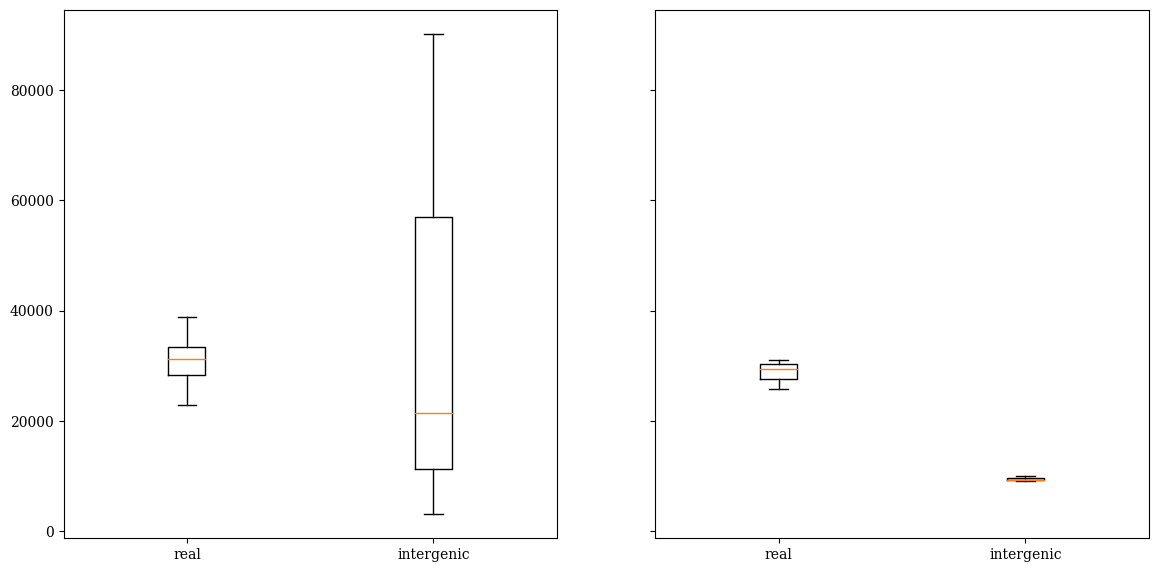

In [5]:
# first let's examine the number of loci per tissue and compare to GTEx

# load the distribution of the number of real and noise loci per tissue first
t_loc = pd.read_csv(base_dir_out+"res.num_locs_tissue")

# now we shall remove any outliers from the data
# q25,q50,q75 = t_loc['real'].quantile([0.25,0.5,0.75])
# iqr = q75-q25
# thw = q75+1.5*iqr
# tlw = q25-1.5*iqr
# ahw = t_loc[t_loc["real"]<=thw]["real"].max()
# alw = t_loc[t_loc["real"]>=tlw]["real"].min()
# t_loc = t_loc[(t_loc['real']<=ahw)&(t_loc['real']>=alw)]

# q25,q50,q75 = t_loc['intergenic'].quantile([0.25,0.5,0.75])
# iqr = q75-q25
# thw = q75+1.5*iqr
# tlw = q25-1.5*iqr
# ahw = t_loc[t_loc["intergenic"]<=thw]["intergenic"].max()
# alw = t_loc[t_loc["intergenic"]>=tlw]["intergenic"].min()
# t_loc = t_loc[(t_loc['intergenic']<=ahw)&(t_loc['intergenic']>=alw)]


fig1, axes = plt.subplots(ncols=2,nrows=1,figsize=(14,7),dpi=100,sharey='row')
axes[0].boxplot(t_loc.T,labels=t_loc.T.index.tolist(), showfliers=False)

num_locs_tissue_sim = pd.concat([pd.DataFrame(num_locs_tissue_real,columns=["real"]),\
                                 pd.DataFrame(num_locs_tissue_intergenic,columns=["intergenic"])],axis=1)
axes[1].boxplot(num_locs_tissue_sim.T,labels=num_locs_tissue_sim.T.index.tolist())

plt.show()

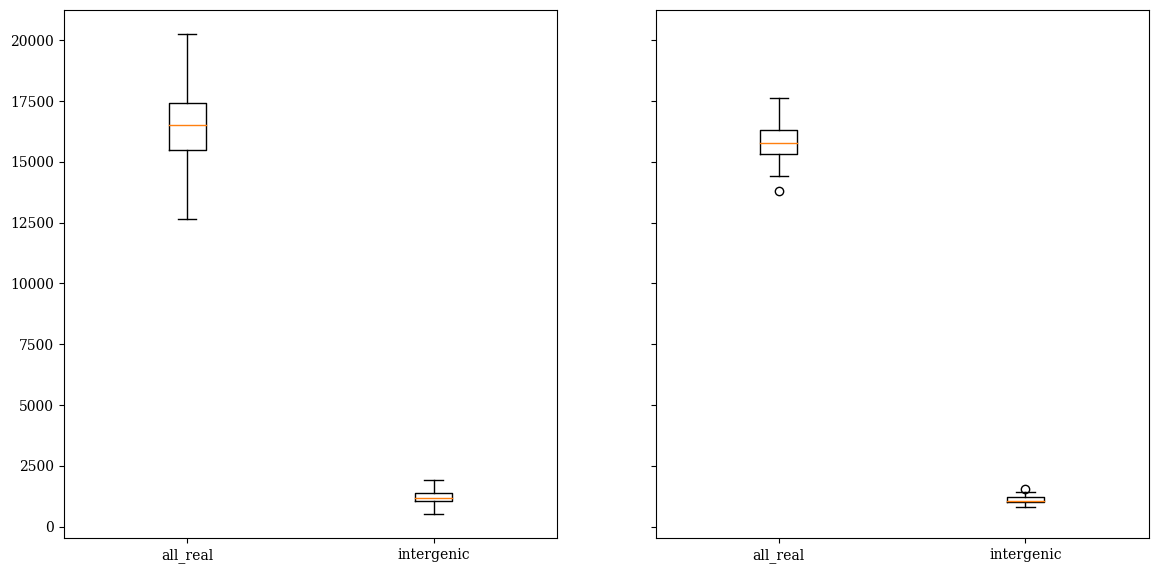

In [6]:
s_loc = pd.read_csv(base_dir_out+"res.num_locs_sample")
s_loc = s_loc[["all_real","intergenic"]]

# for label in s_loc.columns:
#     # now we shall remove any outliers from the data
#     q25,q50,q75 = s_loc[label].quantile([0.25,0.5,0.75])
#     iqr = q75-q25
#     thw = q75+1.5*iqr
#     tlw = q25-1.5*iqr
#     ahw = s_loc[s_loc[label]<=thw][label].max()
#     alw = s_loc[s_loc[label]>=tlw][label].min()
#     s_loc = s_loc[(s_loc[label]<=ahw)&(s_loc[label]>=alw)].reset_index(drop=True)

fig1, axes = plt.subplots(ncols=2,nrows=1,figsize=(14,7),dpi=100,sharey='row')
axes[0].boxplot(s_loc.T,labels=s_loc.T.index.tolist(), showfliers=False)

num_locs_sample_sim = pd.concat([pd.DataFrame(num_locs_sample_real,columns=["all_real"]),\
                                 pd.DataFrame(num_locs_sample_intergenic,columns=["intergenic"])],axis=1)
axes[1].boxplot(num_locs_sample_sim.T,labels=num_locs_sample_sim.T.index.tolist())

plt.show()

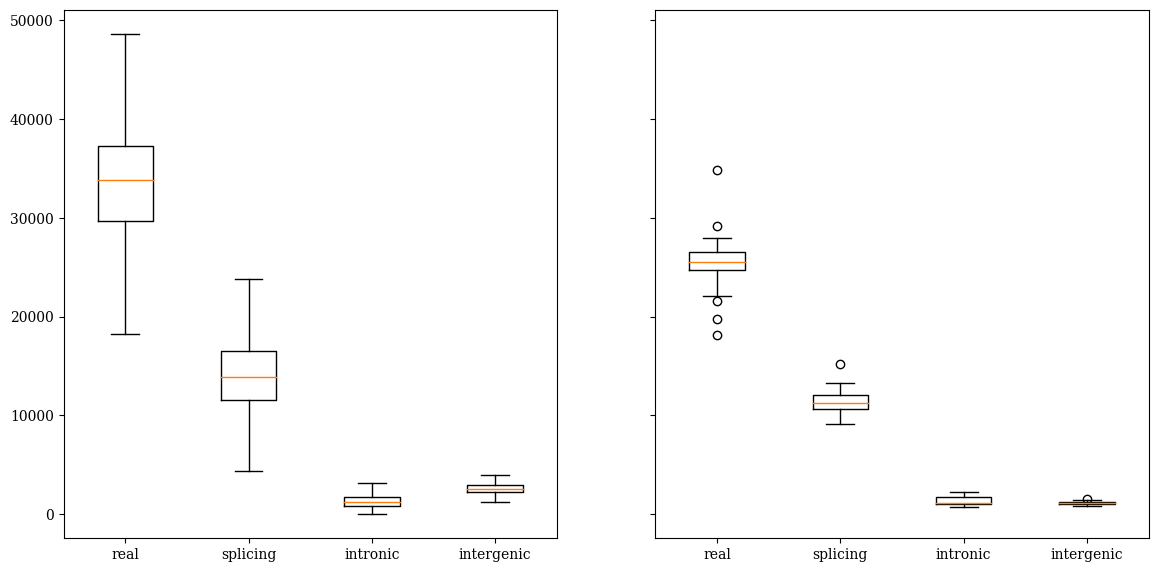

In [8]:
tx_ns = pd.read_csv(base_dir_out+"res.num_tx_per_sample")
tx_ns = tx_ns[["real","splicing","intronic","intergenic"]]

# for label in tx_ns.columns:
#     # now we shall remove any outliers from the data
#     q25,q50,q75 = tx_ns[label].quantile([0.25,0.5,0.75])
#     iqr = q75-q25
#     thw = q75+1.5*iqr
#     tlw = q25-1.5*iqr
#     ahw = tx_ns[tx_ns[label]<=thw][label].max()
#     alw = tx_ns[tx_ns[label]>=tlw][label].min()
#     tx_ns = tx_ns[(tx_ns[label]<=ahw)&(tx_ns[label]>=alw)].reset_index(drop=True)

fig1, axes = plt.subplots(ncols=2,nrows=1,figsize=(14,7),dpi=100,sharey='row')
axes[0].boxplot(tx_ns.T,labels=tx_ns.T.index.tolist(), showfliers=False)

num_txs_sample_sim = pd.concat([pd.DataFrame(num_txs_sample_real,columns=["real"]),\
                                pd.DataFrame(num_txs_sample_splicing,columns=["splicing"]),\
                                pd.DataFrame(num_txs_sample_intronic,columns=["intronic"]),\
                                pd.DataFrame(num_txs_sample_intergenic,columns=["intergenic"])],axis=1)
axes[1].boxplot(num_txs_sample_sim.T,labels=num_txs_sample_sim.T.index.tolist())

plt.show()

In [19]:
frac_real_sample = []
frac_real_locs = []

total_real_locs = []
total_noise_locs = []

for tissue_num in range(num_tissues):
    for sample_num in range(num_samples):
        sum_real = real_gtfs[tissue_num][sample_num]["tpm"].sum()
        sum_splicing = splicing_gtfs[tissue_num][sample_num]["tpm"].sum()
        sum_intronic = intronic_gtfs[tissue_num][sample_num]["tpm"].sum()
        sum_intergenic = intergenic_gtfs[tissue_num][sample_num]["tpm"].sum()
        frac_real_sample.append((sum_real/(sum_real+sum_splicing+sum_intronic+sum_intergenic))*100.0)
        
        realg = real_gtfs[tissue_num][sample_num][["lid","tpm"]].groupby(by="lid").agg({"tpm":"sum"}).reset_index()
        realg.columns = ["lid","tpm_real"]
        splicingg = splicing_gtfs[tissue_num][sample_num][["lid","tpm"]].groupby(by="lid").agg({"tpm":"sum"}).reset_index()
        splicingg.columns = ["lid","tpm_splicing"]
        intronicg = intronic_gtfs[tissue_num][sample_num][["lid","tpm"]].groupby(by="lid").agg({"tpm":"sum"}).reset_index()
        intronicg.columns = ["lid","tpm_intronic"]
        joined = realg.merge(splicingg,on="lid",how="outer",indicator=True)
        joined["tpm_real"] = joined["tpm_real"].fillna(0)
        joined.drop("_merge",axis=1,inplace=True)
        joined = joined.merge(intronicg,on="lid",how="outer",indicator=True)
        joined["tpm_real"] = joined["tpm_real"].fillna(0)
        joined.drop("_merge",axis=1,inplace=True)
        joined["tpm_splicing"] = joined.tpm_splicing.fillna(0)
        joined["tpm_intronic"] = joined.tpm_intronic.fillna(0)
        joined["tpm_total"] = joined.tpm_real+joined.tpm_splicing+joined.tpm_intronic
        joined["frac_tpm_real"] = joined.tpm_real/joined.tpm_total
        joined["total_tpm_noise"] = joined["tpm_splicing"]+joined["tpm_intronic"]
        
        frac_real_locs.extend(joined["frac_tpm_real"].tolist())
        total_real_locs.extend(joined["tpm_real"].tolist())
        total_noise_locs.extend(joined["total_tpm_noise"].tolist())

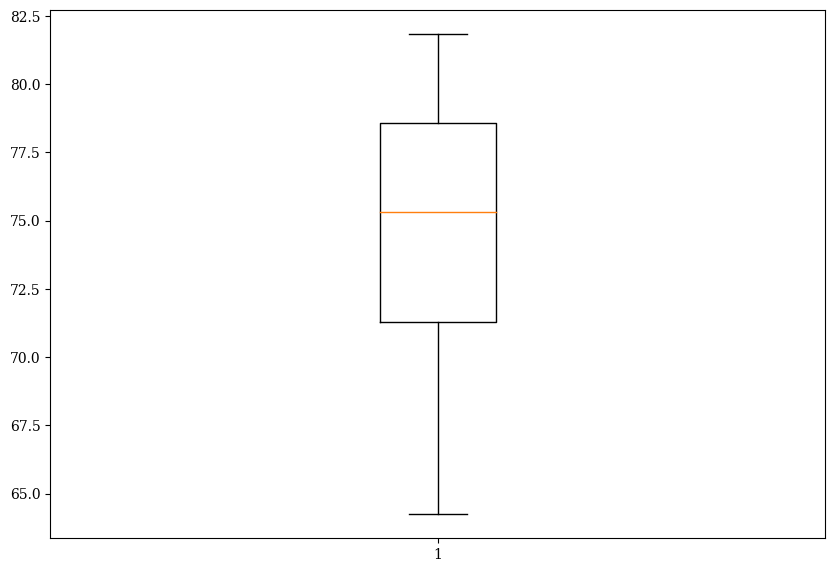

In [20]:
frac_real_sample_df = pd.DataFrame(frac_real_sample,columns=["frac_real"])
fig = plt.subplots(figsize=(10,7),dpi=100)
plt.boxplot(frac_real_sample_df.T)
plt.show()

In [12]:
stats_loc5 = pd.read_csv(base_dir_out+"res.num_tx_per_sample_loc5")
stats_loc5_nt = stats_loc5[["sample","real","splicing","intronic","intergenic"]]
stats_loc5 = stats_loc5[["total_tpm_real","total_tpm_splicing","total_tpm_intronic","total_tpm_intergenic"]]
stats_loc5["tpm_total"] = stats_loc5.total_tpm_real+stats_loc5.total_tpm_splicing+stats_loc5.total_tpm_intronic
stats_loc5["frac_tpm_real"] = stats_loc5.total_tpm_real/stats_loc5.tpm_total
stats_loc5["total_tpm_noise"] = stats_loc5["total_tpm_splicing"]+stats_loc5["total_tpm_intronic"]
stats_loc5.head()

/home/avaraby1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/avaraby1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/avaraby1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

,total_tpm_real,total_tpm_splicing,total_tpm_intronic,total_tpm_intergenic,tpm_total,frac_tpm_real,total_tpm_noise
0,0.00000,4.92635,0.0,0.0,4.92635,0.0,4.92635
1,2.88853,0.00000,0.0,0.0,2.88853,1.0,0.00000
2,2.61178,0.00000,0.0,0.0,2.61178,1.0,0.00000
3,0.00000,1.58056,0.0,0.0,1.58056,0.0,1.58056
4,7.63499,0.00000,0.0,0.0,7.63499,1.0,0.00000


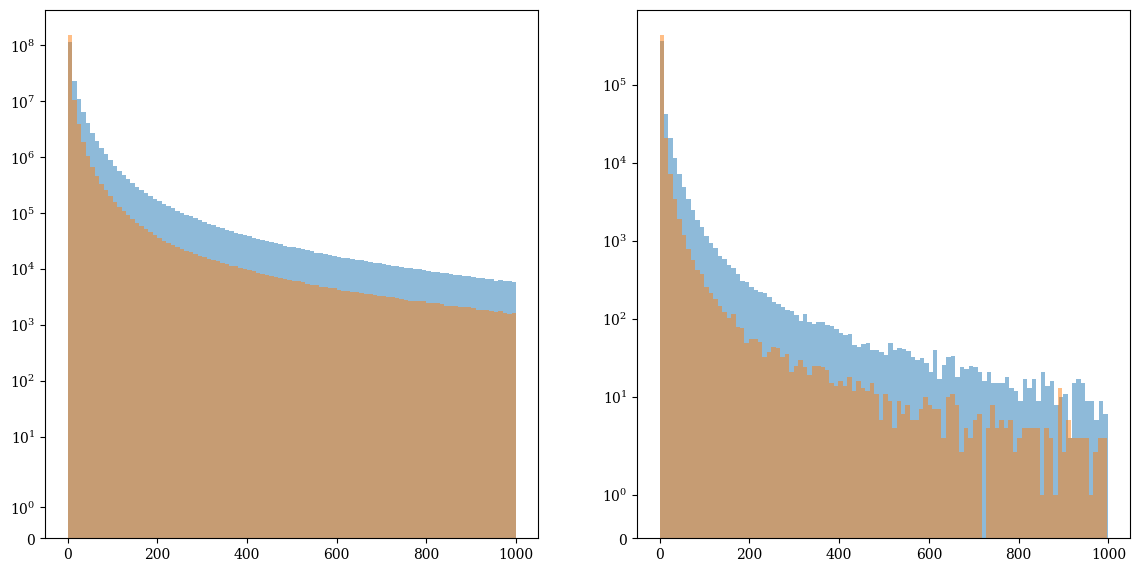

In [13]:
total_locs = pd.concat([pd.DataFrame(total_real_locs,columns=["real"]),\
                        pd.DataFrame(total_noise_locs,columns=["noise"])],axis=1)

fig1, axes = plt.subplots(ncols=2,nrows=1,figsize=(14,7),dpi=100)
axes[0].hist(stats_loc5[(stats_loc5["total_tpm_real"]<1000)]["total_tpm_real"],bins=100,alpha=0.5,label='real')
axes[0].hist(stats_loc5[(stats_loc5["total_tpm_noise"]<1000)]["total_tpm_noise"],bins=100,alpha=0.5,label='noise')
axes[0].set_yscale("symlog")

axes[1].hist(total_locs[(total_locs["real"]<1000)]["real"],bins=100,alpha=0.5,label='real')
axes[1].hist(total_locs[(total_locs["noise"]<1000)]["noise"],bins=100,alpha=0.5,label='noise')
axes[1].set_yscale("symlog")

plt.show()

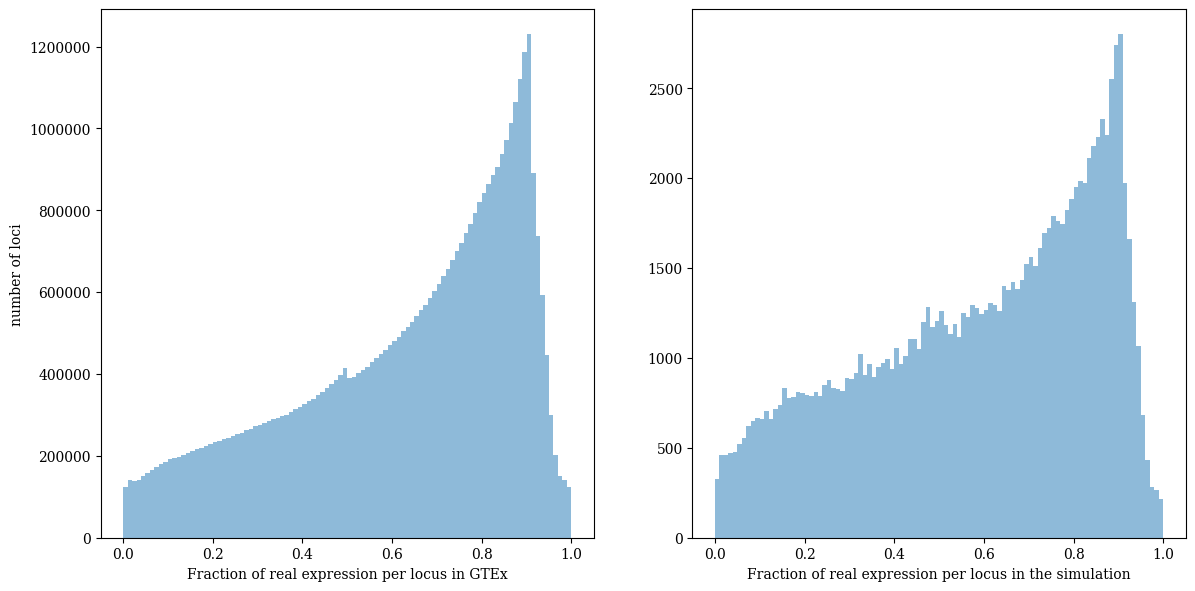

In [23]:
frac_locs = pd.DataFrame(frac_real_locs,columns=["frac_real"])

fig1, axes = plt.subplots(ncols=2,nrows=1,figsize=(14,7),dpi=100)
axes[0].hist(stats_loc5[(stats_loc5["frac_tpm_real"]<1.0)&(stats_loc5["frac_tpm_real"]>0.0)]["frac_tpm_real"],bins=100,alpha=0.5,label='frac_real')

axes[1].hist(frac_locs[(frac_locs["frac_real"]<1.0)&(frac_locs["frac_real"]>0.0)]["frac_real"],bins=100,alpha=0.5,label='frac_real')
axes[0].set_xlabel("Fraction of real expression per locus in GTEx")
axes[1].set_xlabel("Fraction of real expression per locus in the simulation")
axes[0].set_ylabel("number of loci")
plt.show()

In [15]:
real_gtf = pd.read_csv(out_dir+"real.t"+str(0)+"_s"+str(1)+".gtf",sep="\t",names=gff3cols)
splicing_gtf = pd.read_csv(out_dir+"splicing.t"+str(0)+"_s"+str(1)+".gtf",sep="\t",names=gff3cols)
intronic_gtf = pd.read_csv(out_dir+"intronic.t"+str(0)+"_s"+str(1)+".gtf",sep="\t",names=gff3cols)

real_gtf = real_gtf[real_gtf["type"]=="transcript"].reset_index(drop=True)
splicing_gtf = splicing_gtf[splicing_gtf["type"]=="transcript"].reset_index(drop=True)
intronic_gtf = intronic_gtf[intronic_gtf["type"]=="transcript"].reset_index(drop=True)

real_gtf["lid"] = real_gtf.attributes.str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
splicing_gtf["lid"] = splicing_gtf.attributes.str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
intronic_gtf["lid"] = intronic_gtf.attributes.str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]

real_gtf["tid"] = real_gtf.attributes.str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
splicing_gtf["tid"] = splicing_gtf.attributes.str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
intronic_gtf["tid"] = intronic_gtf.attributes.str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]

real_gtf["tpm"] = real_gtf.attributes.str.split("sim_tpm=",expand=True,n=1)[1].str.split(";",expand=True,n=1)[0].astype(float)
splicing_gtf["tpm"] = splicing_gtf.attributes.str.split("sim_tpm=",expand=True,n=1)[1].str.split(";",expand=True,n=1)[0].astype(float)
intronic_gtf["tpm"] = intronic_gtf.attributes.str.split("sim_tpm=",expand=True,n=1)[1].str.split(";",expand=True,n=1)[0].astype(float)

In [16]:
frac_real_locs = []

total_real_locs = []
total_noise_locs = []

sum_real = real_gtf["tpm"].sum()
sum_splicing = splicing_gtf["tpm"].sum()
sum_intronic = intronic_gtf["tpm"].sum()

realg = real_gtf[["lid","tpm"]].groupby(by="lid").agg({"tpm":"sum"}).reset_index()
realg.columns = ["lid","tpm_real"]
splicingg = splicing_gtf[["lid","tpm"]].groupby(by="lid").agg({"tpm":"sum"}).reset_index()
splicingg.columns = ["lid","tpm_splicing"]
intronicg = intronic_gtf[["lid","tpm"]].groupby(by="lid").agg({"tpm":"sum"}).reset_index()
intronicg.columns = ["lid","tpm_intronic"]
joined = realg.merge(splicingg,on="lid",how="outer",indicator=True)
joined["tpm_real"] = joined["tpm_real"].fillna(0)
joined.drop("_merge",axis=1,inplace=True)
joined = joined.merge(intronicg,on="lid",how="outer",indicator=True)
joined["tpm_real"] = joined["tpm_real"].fillna(0)
joined.drop("_merge",axis=1,inplace=True)
joined["tpm_splicing"] = joined.tpm_splicing.fillna(0)
joined["tpm_intronic"] = joined.tpm_intronic.fillna(0)
joined["tpm_total"] = joined.tpm_real+joined.tpm_splicing+joined.tpm_intronic
joined["frac_tpm_real"] = joined.tpm_real/joined.tpm_total
joined["total_tpm_noise"] = joined["tpm_splicing"]+joined["tpm_intronic"]

frac_real_locs.extend(joined["frac_tpm_real"].tolist())
total_real_locs.extend(joined["tpm_real"].tolist())
total_noise_locs.extend(joined["total_tpm_noise"].tolist())

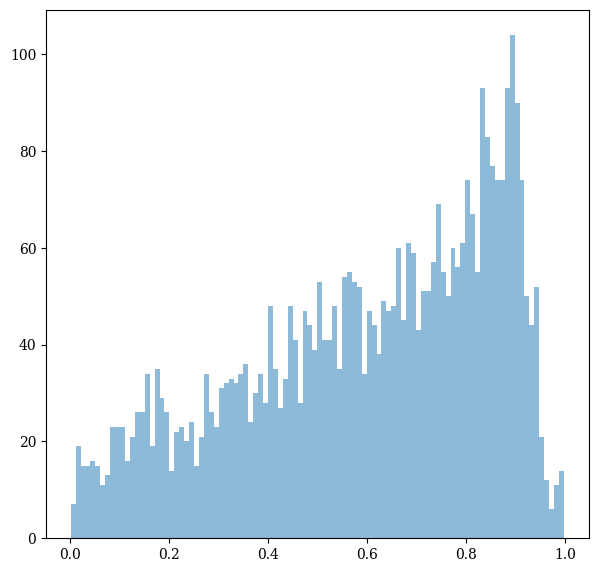

In [17]:
frac_locs = pd.DataFrame(frac_real_locs,columns=["frac_real"])

fig1, axes = plt.subplots(ncols=1,nrows=1,figsize=(7,7),dpi=100)
axes.hist(frac_locs[(frac_locs["frac_real"]<1.0)&(frac_locs["frac_real"]>0.0)]["frac_real"],bins=100,alpha=0.5,label='frac_real')
plt.show()

In [ ]:
# lastly I need to compute the number of transcripts per tissue based on this file, which should be possible
# using the stats_loc5_nt frame

In [ ]:
# let's plot the number of transcripts per locus of each type
num_tx_loc4 = pd.read_csv(base_dir_out+"res.num_tx_per_sample_loc4")[["real","splicing","intronic","polymerase"]]

In [ ]:
num_tx_loc_sample_real = []
num_tx_loc_sample_splicing = []
num_tx_loc_sample_intronic = []


for tissue_num in range(num_tissues):
    for sample_num in range(num_samples):
        num_tx_loc_sample_real.extend(pd.read_csv(out_dir+\
                                                  "real.sub_t"+\
                                                  str(tissue_num)+\
                                                  "_s"+\
                                                  str(sample_num))[["lid",\
                                                                    "tid"]].groupby(by="lid").count().reset_index(drop=True)["tid"].tolist())
        num_tx_loc_sample_splicing.extend(pd.read_csv(out_dir+\
                                                  "splicing.sub_t"+\
                                                  str(tissue_num)+\
                                                  "_s"+\
                                                  str(sample_num))[["lid",\
                                                                    "tid"]].groupby(by="lid").count().reset_index(drop=True)["tid"].tolist())
        num_tx_loc_sample_intronic.extend(pd.read_csv(out_dir+\
                                                  "intronic.sub_t"+\
                                                  str(tissue_num)+\
                                                  "_s"+\
                                                  str(sample_num))[["lid",\
                                                                    "tid"]].groupby(by="lid").count().reset_index(drop=True)["tid"].tolist())

In [ ]:
# let's plot the number of transcripts per locus of each type
fig1, axes = plt.subplots(ncols=2,nrows=3,figsize=(14,21),dpi=100,sharex=True)
axes[0,0].hist(num_tx_loc4[num_tx_loc4["real"]>0]["real"],bins=40,alpha=0.5,label="real")
axes[1,0].hist(num_tx_loc4[num_tx_loc4["splicing"]>0]["splicing"],bins=40,alpha=0.5,label="splicing")
axes[2,0].hist(num_tx_loc4[num_tx_loc4["intronic"]>0]["intronic"],bins=40,alpha=0.5,label="intronic")

axes[0,1].hist(num_tx_loc_sample_real,bins=40,alpha=0.5,label="real")
axes[1,1].hist(num_tx_loc_sample_splicing,bins=40,alpha=0.5,label="splicing")
axes[2,1].hist(num_tx_loc_sample_intronic,bins=40,alpha=0.5,label="intronic")

for x in range(3):
    for y in range(2):
        axes[x,y].set_yscale("symlog")
plt.show()